In [1]:
# pip install contextily

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import contextily as ctx
import numpy as np
import os
import json
import uuid

# Define bounding box of Bali
minx, miny = 114.403381, -8.853592  # Southwest corner
maxx, maxy = 115.716248, -8.035842  # Northeast corner

# Define patch size in km
patch_km = 1 # 1 km x 1 km patches

# Approximate degree size for 20 km tiles
deg_per_km_lat = 1 / 111.32  # degrees per km latitude
deg_per_km_lon = 1 / (111.32 * np.cos(np.radians(miny)))  # adjusted for latitude

delta_lat = patch_km * deg_per_km_lat
delta_lon = patch_km * deg_per_km_lon

# Generate patches
patches = []
x = minx
while x < maxx:
    y = miny
    while y < maxy:
        patch = box(x, y, x + delta_lon, y + delta_lat)
        patches.append(patch)
        y += delta_lat
    x += delta_lon

# Create GeoDataFrame
patches_gdf = gpd.GeoDataFrame({'geometry': patches}, crs='EPSG:4326')

In [3]:
# Load Bali land shapefile and ensure same CRS
bali_land = gpd.read_file('../data/masks/bali_merged.geojson')
bali_land = bali_land.to_crs(patches_gdf.crs)

# Filter patches intersecting with land
patches_on_land = gpd.sjoin(patches_gdf, bali_land, how='inner', predicate='intersects')
patches_on_land = patches_on_land.drop(columns='index_right')

# Convert to Web Mercator for plotting
patches_on_land = patches_on_land.to_crs(epsg=3857)

print(f"Number of raster patches: {len(patches_on_land)}")

Number of raster patches: 5979


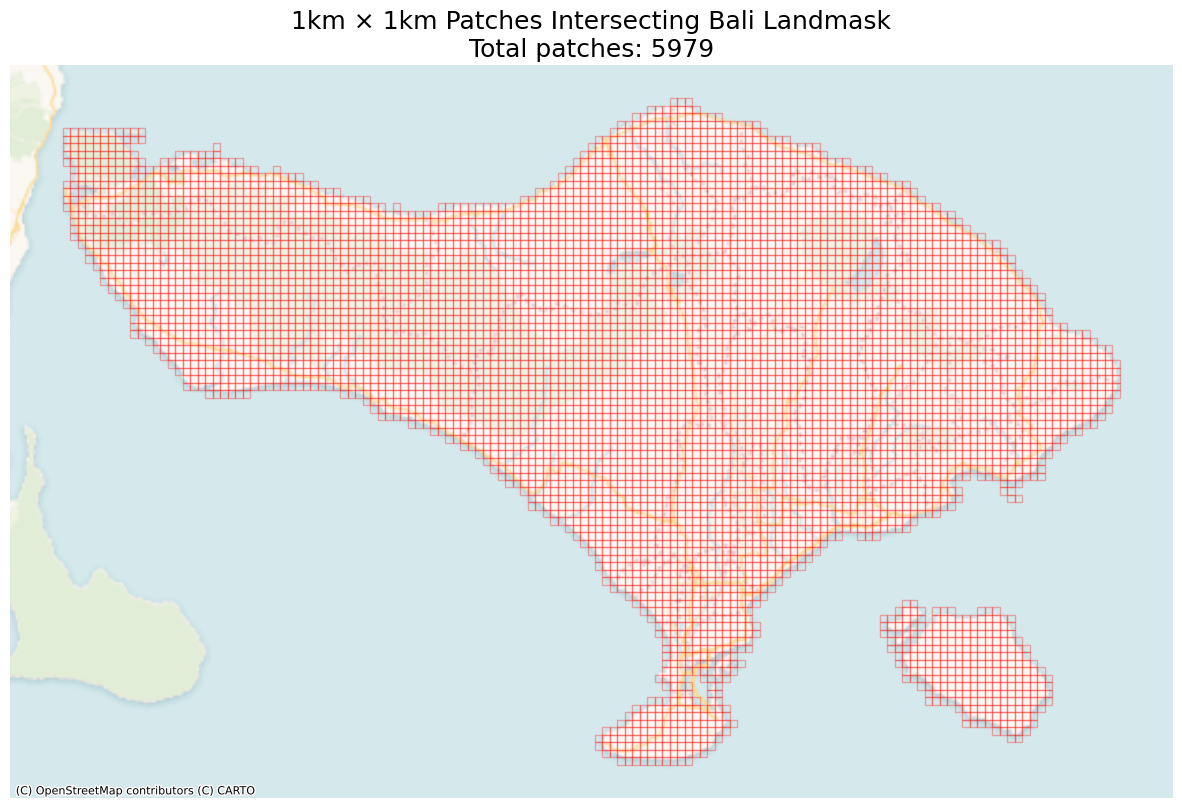

In [4]:
# Plot
fig, ax = plt.subplots(figsize=(15, 15))

# Plot the patches
patches_on_land.plot(ax=ax, facecolor='none', edgecolor='red', alpha=0.3)
# Plot the land mask
# ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels)

# Plot Decorations
ax.set_axis_off()

# Add dynamic title including patch size and count
total_patches = len(patches_on_land)
plt.title(f"{patch_km}km × {patch_km}km Patches Intersecting Bali Landmask\nTotal patches: {total_patches}", fontsize=18)

plt.show()

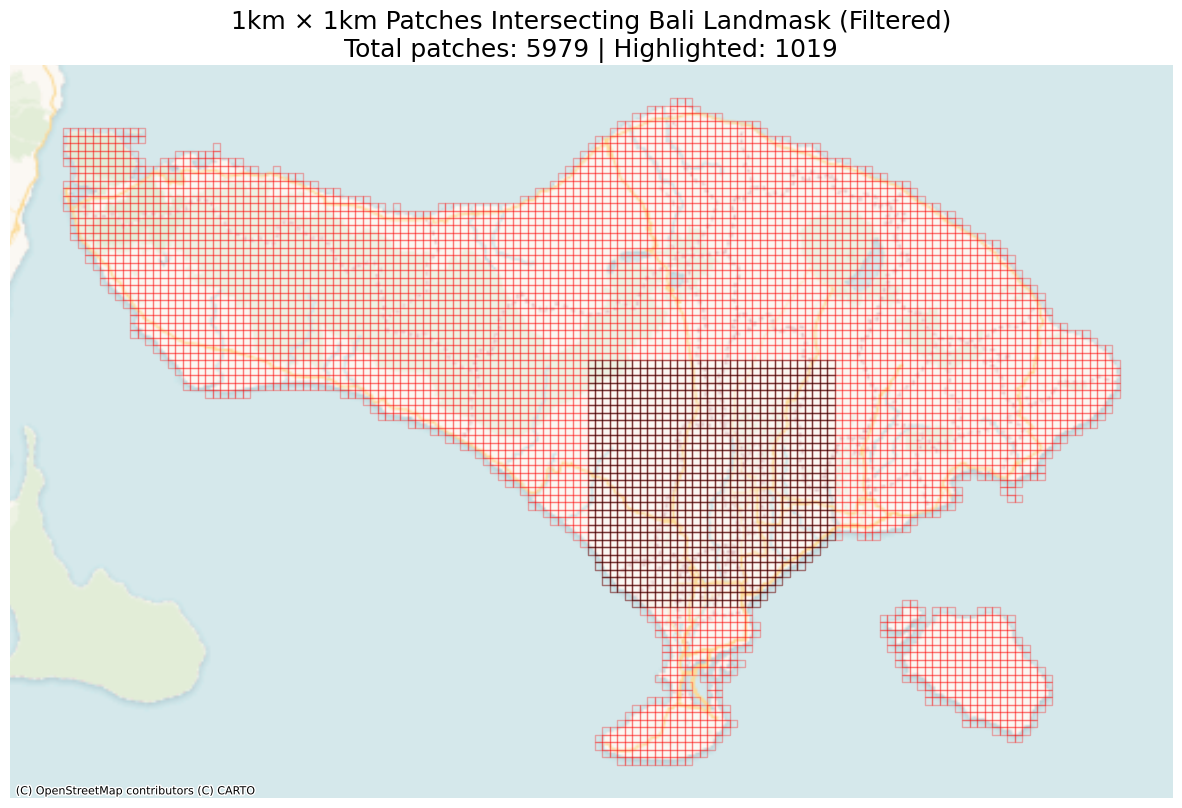

In [5]:
import matplotlib.pyplot as plt
from shapely.geometry import box
import contextily as ctx

# Define the filter bbox in EPSG:3857 (Web Mercator)
filter_bbox_3857 = box(12809890.4777, -967539.9040, 12842414.4333, -935130.6040)

# Filter patches within bbox
highlighted_patches = patches_on_land[patches_on_land.intersects(filter_bbox_3857)]

# Plot all patches and highlight those in the bbox
fig, ax = plt.subplots(figsize=(15, 15))

# All patches: red outline
patches_on_land.plot(ax=ax, facecolor='none', edgecolor='red', alpha=0.3, linewidth=1)

# Highlighted patches: blue outline
highlighted_patches.plot(ax=ax, facecolor='none', edgecolor='black', alpha=0.3, linewidth=1)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels)

# Decorations
ax.set_axis_off()
plt.title(
    f"{patch_km}km × {patch_km}km Patches Intersecting Bali Landmask (Filtered)\n"
    f"Total patches: {len(patches_on_land)} | Highlighted: {len(highlighted_patches)}",
    fontsize=18
)
plt.show()


In [6]:
# ---- Settings ----
output_dir = "../data/patches"
os.makedirs(output_dir, exist_ok=True)

# Assign unique IDs with UUID to all patches
patches_on_land = patches_on_land.reset_index(drop=True)
patches_on_land["patch_id"] = patches_on_land.index.map(
    lambda i: f"patch_{i:05d}_{uuid.uuid4().hex[:8]}"
)

# Filter patches that intersect with the target bbox
highlighted_patches = patches_on_land[patches_on_land.intersects(filter_bbox_3857)].copy()

# Save all land-intersecting patches with unique ID
patches_on_land.to_file(os.path.join(output_dir, "patches_on_land.geojson"), driver="GeoJSON")

# Save only filtered subset
highlighted_patches.to_file(os.path.join(output_dir, "highlighted_patches.geojson"), driver="GeoJSON")

# Save export metadata
metadata = {
    "crs": "EPSG:3857",
    "patch_km": patch_km,
    "patch_size_meters": patch_km * 1000,
    "projection": "Web Mercator",
    "highlight_bbox_epsg3857": {
        "xmin": filter_bbox_3857.bounds[0],
        "ymin": filter_bbox_3857.bounds[1],
        "xmax": filter_bbox_3857.bounds[2],
        "ymax": filter_bbox_3857.bounds[3],
    },
    "total_patches_on_land": len(patches_on_land),
    "highlighted_patches_count": len(highlighted_patches),
    "patch_id_format": "patch_00000_uuid (e.g., patch_00042_a1b2c3d4)"
}

with open(os.path.join(output_dir, "metadata.json"), "w") as f:
    json.dump(metadata, f, indent=4)

print("✅ Export complete:")
print(f"• patches_on_land.geojson → {len(patches_on_land)} patches")
print(f"• highlighted_patches.geojson → {len(highlighted_patches)} patches")
print(f"• metadata.json saved to: {output_dir}")


✅ Export complete:
• patches_on_land.geojson → 5979 patches
• highlighted_patches.geojson → 1019 patches
• metadata.json saved to: ../data/patches
